<a href="https://colab.research.google.com/github/SquirrelLover/FearNet-Implementation/blob/main/FearNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of a Fearnet Variation

Authors: Brady Gho, Lucy Wu

Source: https://arxiv.org/abs/1711.10563

Created on July 25, 2024. Last edited July 25, 2024

# Defining Imports and Meta-parameters

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset
import pdb
from collections import defaultdict
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights

In [4]:
# Define meta-Parameters
Mini_batch = 450
Dropout = 0.5
VAE_dims = np.array([256])
Classifier_Dims = np.array([2048, 600, 100])
Input_Dim = 2048
Learning_Rate = 2e-3
HC_Epochs = 25
mPFC_Epochs = 35
BLA_Epochs = 15

torch.manual_seed(42) # seed set for reproducibility

# Loading and Processing Data

Files already downloaded and verified
Files already downloaded and verified
Train Loader Images:


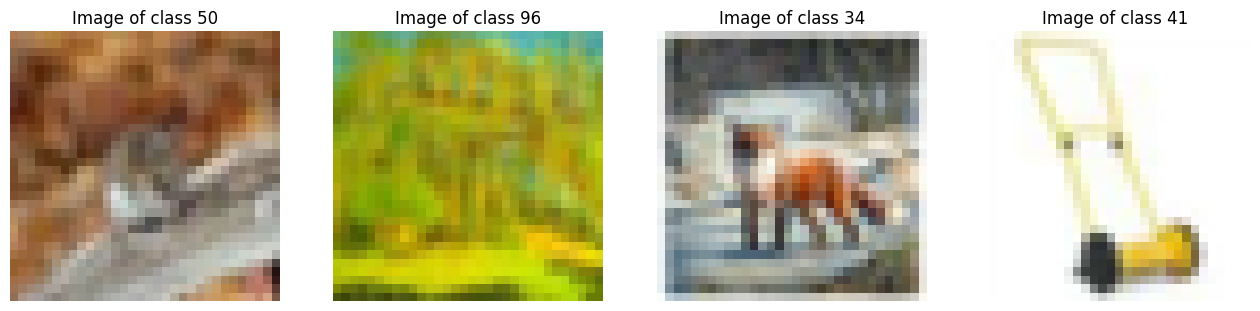

In [38]:
# Load Dataset (CIFAR-100)

transform = transforms.Compose([
    transforms.ToTensor(),
    # insert more transformations of data i.e. normalization
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, transform = transform, download = True)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, transform = transform, download = True)

train_loader = DataLoader(train_data, batch_size = Mini_batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size = Mini_batch, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# view a couple of sample images to make sure they are loaded

def display_img_examples(loader):
  images, labels = next(iter(loader))
  images = images.cpu().detach().numpy()
  plt.figure(figsize=(16, 4))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.axis('off')
    plt.title(f"Image of class {labels[i].item()}")
  plt.show()

print("Train Loader Images:")
display_img_examples(train_loader)

In [32]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels.long()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

    def add_features(self, new_features, new_labels):
        self.features = torch.cat((self.features, new_features), dim=0)
        self.labels = torch.cat((self.labels, new_labels), dim=0)

In [42]:
# pass data through Resnet processing

resnet = resnet50(weights=ResNet50_Weights.DEFAULT) # using ResNet default weights
resnet = resnet.to(device)
resnet.eval()
resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)
# remove all fc layers except the last one

def resnet_process(data_loader):
  num_images = len(data_loader) * data_loader.batch_size
  feature_vectors = torch.zeros((num_images, 2048), device=device) # 2048 comes from output of Resnet processing
  labels = torch.zeros(num_images, device=device)

  with torch.no_grad():
    for i, (images, labels_batch) in enumerate(data_loader):
      images = images.to(device)
      labels_batch = labels_batch.to(device)
      features_batch = resnet_feature_extractor(images).squeeze()
      start_index = i * Mini_batch
      end_index = start_index + features_batch.shape[0]
      feature_vectors[start_index:end_index] = features_batch
      labels[start_index:end_index] = labels_batch

  return DataLoader(FeatureDataset(feature_vectors, labels))

train_loader_processed = resnet_process(train_loader)
test_loader_processed = resnet_process(test_loader)

# Evaluate the Performance of Resnet on CIFAR-100

In [ ]:
resnet_test = resnet50(pretrained=True)
num_features = resnet_test.fc.in_features
resnet_test.fc = nn.Linear(num_features, 100)
resnet_test.to(device)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_test.parameters(), lr=0.001)

# training function
def training_step(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(data_loader)
    return average_loss

# calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# training
num_epochs = 30
for epoch in range(num_epochs):
    avg_loss = training_step(resnet_test, train_loader, criterion, optimizer, device)
    accuracy = calculate_accuracy(resnet_test, test_loader, device)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {accuracy}%")

In [ ]:
# test accuracy

def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(resnet_test, test_loader, device)
print(f'Test Accuracy of the model on the 10000 test images: {test_accuracy:.2f}%')


# Hippocampus Implementation

In [47]:
# define HC

class HC(nn.Module):
  def __init__(self, classifier_dims = Classifier_Dims, learning_rate= Learning_Rate, p_dropout=Dropout):
    super(HC, self).__init__()

    self.short_term_memory = FeatureDataset()

    classifier_layers = []
    current_dim = classifier_dims[0]

    if len(classifier_dims)!=1:
      # Avoid dropping out the first layer of processing and output layer
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ReLU())

      for i in range(1, len(classifier_dims)-1):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ReLU())
        classifier_layers.append(nn.Dropout(p=p_dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*classifier_layers)

    # Using Adam Optimizer
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
    self.CrossEntropyLoss = nn.CrossEntropyLoss()

  def forward(self, x, is_storing = False):
    if (is_storing):
      features = x[0].squeeze()
      labels = x[1].squeeze()
      self.short_term_memory.add_features(features, labels)
    class_logits = self.classifier(x)
    return class_logits

  def clear_memory(self):
    memory = self.short_term_memory
    self.short_term_memory = FeatureDataset()
    return memory

  def training_step(self, dataloader):
    total_loss = 0

    self.train()
    optimizer = self.optimizer

    for features, targets in dataloader:
      optimizer.zero_grad()

      class_logits = self.forward(features, is_storing=True)
      loss = self.CrossEntropyLoss(class_logits, targets)

      loss.backward()
      optimizer.step()

      total_loss += loss

    return (total_loss / (len(dataloader) * dataloader.batch_size))

  def calc_accuracy(self, dataloader):
    total_correct = 0

    self.eval()
    with torch.no_grad():
      for features, targets in dataloader:
        predictions = self.forward(features, is_storing=False)
        predictions = torch.argmax(predictions, dim=1)

        correct = (predictions == targets).sum().item()
        total_correct += correct

    return (total_correct / (len(dataloader) * dataloader.batch_size))*100


In [49]:
# Testing

hippocampus = HC()
hippocampus.to(device)

loss_history = []
for epoch in range(50):
  loss = hippocampus.training_step(train_loader_processed)
  loss_history.append(loss)
  accuracy = hippocampus.calc_accuracy(train_loader_processed)
  print(f"Epoch {epoch+1}: Loss is {loss:.4f}, Accuracy is {accuracy:.4f}%")

print(f"Accuracy is {hippocampus.calc_accuracy(test_loader_processed):.4f}%")

Epoch 1: Loss is 4.6347, Accuracy is 2.2540


KeyboardInterrupt: 

# Pre-frontal Cortex  Implementation

In [19]:
# define mPFC (long term)

class mPFC(nn.Module):
  def __init__(self, input_dim=2048, autoencoder_hidden_dims = np.array([1024, 512]), classifier_dims = np.array([100]), lambda_values=[1e4, 1, 0.1], learning_rate=5e-4):
    super(mPFC, self).__init__()
    # encoder
    encoder_layers = []
    current_dim = input_dim
    encoder_layers.append(nn.ELU())
    for hidden_dim in autoencoder_hidden_dims:
      encoder_layers.append(nn.Linear(current_dim, hidden_dim))
      encoder_layers.append(nn.ELU())
      current_dim = hidden_dim
    self.encoder = nn.Sequential(*encoder_layers)

    # decoder
    decoder_layers = []
    hidden_dims_reversed = list(autoencoder_hidden_dims[::-1])
    for hidden_dim in hidden_dims_reversed:
      decoder_layers.append(nn.Linear(current_dim, hidden_dim))
      decoder_layers.append(nn.ELU())
      current_dim = hidden_dim
    decoder_layers.append(nn.Linear(current_dim, input_dim))
    decoder_layers.append(nn.ELU())
    self.decoder = nn.Sequential(*decoder_layers)

    #classifier
    current_dim = autoencoder_hidden_dims[-1]
    classifier_layers= []

    if len(classifier_dims) != 1:
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ELU())
      current_dim = classifier_dims[0]

      for i in range(1, len(classifier_dims)-1):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ELU())
        classifier_layers.append(nn.Dropout(p=Dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*classifier_layers)

    # lambda
    self.lambda_values = torch.tensor(lambda_values if lambda_values else [1.0] * len(autoencoder_hidden_dims), dtype=torch.float32)

    # optimizer
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    #session number
    self.class_means = defaultdict(dict)
    self.class_covariances = defaultdict(dict)

  def encoder_forward(self, x):
    encoder_intermediates = [x]
    for layer in self.encoder:
      x = layer(x)
      encoder_intermediates.append(x)
    encoded = encoder_intermediates[-1]
    return encoded, encoder_intermediates

  def decoder_forward(self, x):
    decoder_intermediates = [x]
    for layer in self.decoder:
      x = layer(x)
      decoder_intermediates.append(x)
    pseudo_img = decoder_intermediates[-1]
    return pseudo_img, list(decoder_intermediates[::-1])

  def classify(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def compute_loss(self, class_logits, targets, encoder_intermediates, decoder_intermediates):
    # classification loss
    classification_loss = nn.CrossEntropyLoss()(class_logits, targets)

    # reconstruction loss with lambda weighting
    reconstruction_loss = 0
    for i in range(len(self.lambda_values)):
      encoder_hidden = encoder_intermediates[i]
      decoder_hidden = decoder_intermediates[i]
      diff = encoder_hidden - decoder_hidden
      squared_diff = diff.pow(2)
      layer_loss = squared_diff.sum()
      reconstruction_loss += self.lambda_values[i] * layer_loss

    # total loss
    total_loss = classification_loss + reconstruction_loss

    return classification_loss, reconstruction_loss, total_loss

  def training_step(self, data_loader, device):
    self.train()

    total_classification_loss = 0
    total_reconstruction_loss = 0
    total_total_loss = 0

    for x, targets in data_loader:
      x, targets = x.to(device), targets.to(device)

      # forward pass
      encoded, encoder_intermediates = self.encoder_forward(x)
      pseudo_img, decoder_intermediates = self.decoder_forward(encoded)
      class_logits = self.classify(encoded)

      # compute losses
      classification_loss, reconstruction_loss, total_loss = self.compute_loss(
        class_logits, targets, encoder_intermediates, decoder_intermediates
      )

      # zero gradients
      self.optimizer.zero_grad()

      # backward pass
      classification_loss.backward(retain_graph=True)
      classifier_grads = {name: param.grad.clone() for name, param in self.classifier.named_parameters()}
      reconstruction_loss.backward(retain_graph=True)
      decoder_grads = {name: param.grad.clone() for name, param in self.decoder.named_parameters()}
      total_loss.backward()
      encoder_grads = {name: param.grad.clone() for name, param in self.encoder.named_parameters()}

      # optimizer
      encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=self.optimizer.defaults['lr'])
      encoder_optimizer.step()
      classifier_optimizer = optim.Adam(self.classifier.parameters(), lr=self.optimizer.defaults['lr'])
      classifier_optimizer.step()
      decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=self.optimizer.defaults['lr'])
      decoder_optimizer.step()

      # update parameters
      for name, param in self.classifier.named_parameters():
        if param.grad is not None:
          param.grad.data = classifier_grads[name].data
      for name, param in self.decoder.named_parameters():
        if param.grad is not None:
          param.grad.data = decoder_grads[name].data
      for name, param in self.encoder.named_parameters():
        if param.grad is not None:
          param.grad.data = encoder_grads[name].data

      # add losses to total
      total_classification_loss += classification_loss.item()
      total_reconstruction_loss += reconstruction_loss.item()
      total_total_loss += total_loss.item()

    # average loss
    average_classification_loss = total_classification_loss / len(data_loader)
    average_reconstruction_loss = total_reconstruction_loss / len(data_loader)
    average_total_loss = total_total_loss / len(data_loader)

    return average_classification_loss, average_reconstruction_loss, average_total_loss

  def consolidate_statistics(self):
    # compute the average mean vector and covariance matrix for each class
    for label in self.class_means:
      if self.class_means[label]:
        means = torch.stack(self.class_means[label])
        covariances = torch.stack(self.class_covariances[label])

        # average the mean vectors and covariance matrices
        consolidated_mean = means.mean(dim=0)
        consolidated_covariance = covariances.mean(dim=0)

        # update the consolidated statistics
        self.class_means[label] = consolidated_mean
        self.class_covariances[label] = consolidated_covariance

  def generate_statistics(self, feature_vectors, labels, device):
    # current session class statistics
    class_features = defaultdict(list)

    for feature, label in zip(feature_vectors, labels):
      class_features[label.item()].append(feature)

    for label, features in class_features.items():
      features = torch.stack(features).to(device)
      mean_vector = features.mean(dim=0)
      centered_features = features - mean_vector
      covariance_matrix = torch.mm(centered_features.t(), centered_features) / (features.size(0) - 1)

      # append the current session's statistics
      self.class_means[label].append(mean_vector)
      self.class_covariances[label].append(covariance_matrix)

      self.consolidate_statistics()

  def pseudoimg_from_statistics(self, num_examples_per_class, device):
    self.eval()

    pseudo_examples = []
    pseudo_labels = []

    for label, mean_vector in self.class_means.items():
      if isinstance(mean_vector, torch.Tensor):
        covariance_matrix = self.class_covariances[label]

        # create a multivariate normal distribution
        mvn = dist.MultivariateNormal(mean_vector, covariance_matrix)

        # generate pseudo-examples
        examples = mvn.sample((num_examples_per_class,)).to(device)
        labels = torch.full((num_examples_per_class,), label, dtype=torch.long, device=device)

        pseudo_examples.append(examples)
        pseudo_labels.append(labels)

    pseudo_examples = torch.cat(pseudo_examples)
    pseudo_labels = torch.cat(pseudo_labels)

    return pseudo_examples, pseudo_labels

  def calculate_accuracy(self, data_loader, device):
    self.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for x, targets in data_loader:
        x, targets = x.to(device), targets.to(device)
        encoded, _ = self.encoder_forward(x)
        class_logits = self.classify(encoded)
        _, predicted = torch.max(class_logits.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

mPFC = mPFC()

# BLA Implementation

In [13]:
# Define BLA

class BLA(nn.Module):

  def __init__(self, classifier_dims = Classifier_Dims, learning_rate= Learning_Rate, p_dropout=Dropout):
    super(BLA, self).__init__()

    classifier_layers = []
    current_dim = classifier_dims[0]

    if len(classifier_dims)!=1:
      # Avoid dropping out the first layer of processing and output layer
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ReLU())

      for i in range(1, len(classifier_dims)):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ReLU())
        classifier_layers.append(nn.Dropout(p=p_dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, 1))

    self.classifier = nn.Sequential(*classifier_layers)

    # Using Adam Optimizer
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)


  def forward(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def training_step(self, dataloader, HC, mPFC):
    total_loss = 0

    self.train()
    HC.eval()
    mPFC.eval()
    for features, label in dataloader:
      HC_logits = []
      mPFC_logits = []

      with torch.no_grad():
        HC_logits = HC.forward(features)
        mPFC_logits = mPFC.forward(features)

      optimizer = self.optimizer
      optimizer.zero_grad()

      class_prob = self.Softmax(self.forward(features))

      HC_prob = nn.Softmax(HC_logits)
      mPFC_prob = nn.Softmax(mPFC_logits)

      loss_fn = nn.CrossEntropyLoss()

      HC_loss = loss_fn(HC_prob, labels)
      mPFC_loss = loss_fn(mPFC_prob, labels)

      # Determine if HC or mPFC is more accurate
      target_is_HC = HC_loss > mPFC_loss
      target_is_HC = target_is_HC.float().view(-1, 1)  # Convert to float and reshape for broadcasting

      # Calculate the BLA loss based on whether the prediction aligns with the more accurate model
      BLA_target = target_is_HC
      BLA_loss = nn.BCELoss()(class_prob, BLA_target)

      BLA_loss.backwards()
      optimizer.step()

      total_loss += BLA_loss

    return (total_loss / (len(dataloader) * dataloader.batch_size))

Bla = BLA()

# Dual Memory System Model

In [20]:
# dmsm

class DMSM(nn.Module):
  def __init__(self, input_dim=Input_Dim, classifier_dims = Classifier_Dims, learning_rate=Learning_Rate, p_dropout=Dropout, lambda_values = [1e4, 1.0, 0.1]):
    super(DMSM, self).__init__()
    self.mPFC = mPFC(input_dim, np.array([1024, 512]), classifier_dims, lambda_values, learning_rate)
    self.HC = HC(classifier_dims, learning_rate, p_dropout)
    self.BLA()

  def training(self, dataloader, HC_epochs = HC_Epochs, BLA_epochs = BLA_Epochs):
    mPFC = self.mPFC
    HC = self.HC
    BLA = self.BLA

    HC_loss_history = []
    BLA_loss_history = []

    # Train HC
    for epoch in range(HC_epochs):
      HC_loss_history.append(HC.training_step(dataloader))

    # Integrate hallucinated images into the dataloader


    # Train BLA
    for epoch in range(BLA_epochs):
      BLA_loss_history.append(BLA.training_step(dataloader))

    return HC_loss_history, BLA_loss_history

  def sleep(self, mPFC_Epochs = mPFC_Epochs):
    mPFC = self.mPFC
    HC = self.HC
    BLA = self.BLA

    mPFC_loss_history = []

    short_term_data = HC.clear_memory()

    # Integrate hallucinated images into short term memory data
    #
    #
    #
    #

    for epoch in range(mPFC_Epochs):
      mPFC_Epochs.training_step()

  def eval(self, dataloader):
    mPFC = self.mPFC
    HC = self.HC
    BLA = self.BLA

    HC.eval()
    mPFC.eval()
    BLA.eval()

    predictions = BLA.forward(dataloader)
    predictions_rounded = torch.round(predictions)

    HC_mask = (predictions_rounded == 0).squeeze()
    mPFC_mask = (predictions_rounded == 1).squeeze()

    HC_output = HC.forward(dataloader[HC_mask])
    mPFC_output = mPFC.forward(dataloader[mPFC_mask])

    # Combine the results
    combined_output = torch.zeros_like(hc_predictions)
    combined_output[HC_mask] = HC_output
    combined_output[mPFC_mask] = mPFC_output

    return combined_output

DMSM = DMSM()


NotImplementedError: Module [mPFC] is missing the required "forward" function

In [ ]:
# Training

